<a href="https://colab.research.google.com/github/pragyasingh7/BTP-PSD/blob/master/BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#-----------------------
#--- Second semester ---
#-----------------------

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Zip file for the training data : TransferXL-08v21CrTv7WCMF.zip

In [0]:
#--- imports ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#import torch
#from torch import nn, optim
#import torch.nn.functional as F

from sklearn.cluster import DBSCAN
"""
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import normalize
"""

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier

In [0]:
# changing graph display parameter to adjust for dark theme in google colab
# you can change as per your requirements
plt.rcParams.update({'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

In [0]:
# Unzip the dataset
!unzip /content/drive/My\ Drive/TransferXL-08v21CrTv7WCMF.zip
!ls

In [0]:
data = np.genfromtxt('traindata.csv', delimiter=",")
# last column of all the datapoints in Nan, hence removing that column
# some of the rows also contain Nan vales, removing them as well
reduced_data = data[~np.isnan(data[:, :4]).any(axis=1)]

In [0]:
"""
#--- Code and result of initial data exploration ---#

data.shape : (57930, 5)
total_values = data.shape[0]*data.shape[1]
nan_values = np.count_nonzero(np.isnan(data))
nan_values/total_values*100.0 : 20.001380977041254
print(total_values) : 289650
print(nan_values) : 57934

reduced_data.shape : (57929, 5)
"""

In [0]:
#--- Plotting different columns ---

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

t = np.arange(reduced_data.shape[0])  # generating linearly spaced data points

ax[0, 0].plot(t, reduced_data[:, 0])
ax[0, 0].title.set_text('plot of column 0 vs equally spaced points')

ax[0, 1].plot(reduced_data[:1000, 0], reduced_data[:1000, 1])
ax[0, 1].title.set_text('column 1')

ax[1, 0].plot(reduced_data[:1000, 0], reduced_data[:1000, 3])
ax[1, 0].title.set_text('column 3')

ax[1, 1].plot(reduced_data[:1000, 0], reduced_data[:1000, 2])
ax[1, 1].title.set_text('column 2')

plt.show()

In [0]:
#--- Plotting original data ---

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#plt.figure(figsize=(30, 30))
ax[0].scatter(reduced_data[:, 1], reduced_data[:, 2], s=0.5)
ax[0].title.set_text('original data')
ax[0].set_xlabel('Total area')
ax[0].set_ylabel('Tail area')

"""
# Normalization Tried: makes no difference
reduced_data_norm = normalize(reduced_data[:, 1:3], axis=0)
ax[1].scatter(reduced_data_norm[:, 0], reduced_data_norm[:, 1], s=1)
ax[1].title.set_text('with normalization')
"""

# separate data points based on margin value
data_neut = reduced_data[reduced_data[:, 3]>=0.5]
data_gamma = reduced_data[reduced_data[:, 3]<0.5]

#print(data_gamma.shape[0]/reduced_data.shape[0],
#      data_neut.shape[0]/reduced_data.shape[0])

ax[1].scatter(data_neut[:, 1], data_neut[:, 2], s=0.5, label='neutron')
ax[1].scatter(data_gamma[:, 1], data_gamma[:, 2], s=0.5, label='gamma')
ax[1].title.set_text('data with margin set to 0.5')
ax[1].set_xlabel('Total area')
ax[1].set_ylabel('Tail area')
ax[1].legend(loc="lower right")
plt.show()
# There seems to be clear demarcation between the two when plotting tail area vs total area

In [0]:
#--- PCA transformed data ---

pca = PCA()
x_pca = pca.fit_transform(reduced_data[:, 1:3])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#plt.figure(figsize=(30, 30))
ax[0].scatter(x_pca[:, 0], x_pca[:, 1], s=0.5)
ax[0].title.set_text('pca transformed data')

x_pca_neut = x_pca[reduced_data[:, 3]>0.5]
x_pca_gamma = x_pca[reduced_data[:, 3]<=0.5]

ax[1].scatter(x_pca_neut[:, 0], x_pca_neut[:, 1], s=0.5, label='neutron')
ax[1].scatter(x_pca_gamma[:, 0], x_pca_gamma[:, 1], s=0.5, label='gamma')
ax[1].title.set_text('pca transformed data with margin set to 0.5')
ax[1].legend(loc="lower right")

plt.show()

In [0]:
#--- As the data is highly dense in the lower region, trying log transformation ---

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
#plt.figure(figsize=(30, 30))

reduced_data_log = np.log(reduced_data[:, 1:3])

ax[0].scatter(reduced_data_log[:, 0], reduced_data_log[:, 1], s=0.5)
ax[0].title.set_text('log transformed data')
ax[0].set_xlabel('Total area')
ax[0].set_ylabel('Tail area')

data_neut_log = reduced_data_log[reduced_data[:, 3]>0.5]
data_gamma_log = reduced_data_log[reduced_data[:, 3]<=0.5]

ax[1].scatter(data_neut_log[:, 0], data_neut_log[:, 1], s=0.5, label='neutron')
ax[1].scatter(data_gamma_log[:, 0], data_gamma_log[:, 1], s=0.5, label='gamma')
ax[1].title.set_text('log transformed data with margin set to 0.5')
ax[1].set_xlabel('Total area')
ax[1].set_ylabel('Tail area')
ax[1].legend(loc="lower right")

plt.show()

In [0]:
#--- Applying PCA on the log transformed data ---

pca = PCA()
log_pca_data = pca.fit_transform(reduced_data_log)

# To compare the effect of the equality sign
log_pca_neut = log_pca_data[reduced_data[:, 3]>=0.5]
log_pca_gamma = log_pca_data[reduced_data[:, 3]<0.5]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(log_pca_data[:, 0], log_pca_data[:, 1], s=0.5)
ax[0].title.set_text('(log + pca) transformed data')

ax[1].scatter(log_pca_neut[:, 0], log_pca_neut[:, 1], s=0.5, label='neutron')
ax[1].scatter(log_pca_gamma[:, 0], log_pca_gamma[:, 1], s=0.5, label='gamma')
ax[1].title.set_text('(log + pca) transformed data with margin set to 0.5')
ax[1].legend(loc="lower right")
plt.show()

In [0]:
#--- Result of slightly changing the boundary conditions ---

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

neut_0 = reduced_data[reduced_data[:, 3]>=0.5]
gamma_0 = reduced_data[reduced_data[:, 3]<0.5]
ax[0].scatter(neut_0[:, 1], neut_0[:, 2], s=0.5, label='neutron')
ax[0].scatter(gamma_0[:, 1], gamma_0[:, 2], s=0.5, label='gamma')
ax[0].title.set_text('neutron: ratio >=0.5')
ax[0].legend(loc="lower right")

neut_1 = reduced_data[reduced_data[:, 3]>0.5]
gamma_1 = reduced_data[reduced_data[:, 3]<=0.5]
ax[1].scatter(neut_1[:, 1], neut_1[:, 2], s=0.5, label='neutron')
ax[1].scatter(gamma_1[:, 1], gamma_1[:, 2], s=0.5, label='gamma')
ax[1].title.set_text('neutron: ratio >0.5')
ax[1].legend(loc="lower right")

plt.show()

print(gamma_0[:, 0].size/reduced_data[:, 0].size, gamma_1[:, 0].size/reduced_data[:, 0].size)
# ~5% decrease in datapoints labelled as gamma on chaging the equality condition

In [0]:
#--- Trying various clustering methods ---#

"""
Aim:
  To study various clustering methods and compare their performances.

Results:
  1. Both kmeans and Bayesian Gaussian Mixture model gives extremely poor performance.
  Were producing simply a vertical split. This could be attributed to the fact that 
  both methods depend on cluster center initialization and uses euclidean distance as metric.
  Their implementation leads to the vertical split as the most optimum one.

  2. Density based clustering shows promise, however the performace is highly dependent on the 
  value of the parameter 'eps'. Number of clusters is inversly proportional to value of 'eps'.
  
  3. All the other methods are extremely resource intensive and parameter dependent hence
  hyperparameter optimization isn't feasible. 
"""
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph

#connectivity = kneighbors_graph(log_pca_data, n_neighbors=3, include_self=False)  # required as a parameter in a few clustering methods tried

#kmeans = sklearn.cluster.KMeans(init="k-means++", n_clusters=3, n_init=10)
#bgm = sklearn.mixture.BayesianGaussianMixture(n_components=2)
dbscn = sklearn.cluster.DBSCAN(eps=0.0137)
#spec = sklearn.cluster.SpectralClustering(n_clusters=2)  # Session is crashing while trying to apply this method
#ms = MeanShift()  # Takes too long
#gmm = GaussianMixture(n_components=2, covariance_type="full")  # same issue as k-means and all
#optics = OPTICS()  # tried multiple values of the parameter, giving only one cluster
#avg_link = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=2, connectivity=connectivity)
#birch = Birch(n_clusters=2)
#ward = AgglomerativeClustering(linkage="ward", n_clusters=2, connectivity=connectivity)
#ap = AffinityPropogation(damping=.77, preference=-240)


pred = dbscn.fit_predict(log_pca_data)
pred_0 = log_pca_data[pred==0]
pred_1 = log_pca_data[pred==1]
pred_x = log_pca_data[(pred!=1) & (pred!=0)]   # useful when using DBSCAN

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5, label='0')
ax[0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5, label='1')
ax[0].scatter(pred_x[:, 0], pred_x[:, 1], s=0.5, label='other labels')
ax[0].title.set_text('DBSCAN result')
ax[1].legend(loc="lower right")

ax[1].scatter(log_pca_data[:, 0], log_pca_data[:, 1], s=0.5)
plt.show()

In [0]:
# --- Hyperparameter optimization for DBSCAN ---
"""
Aim:
  As DBSCAN shows satisfactory performance, using grid search on log uniform
  space of hyperparameters(trying for eps only due to limited compute power).

  Grid search: to narrow down search space. {don't try values greater than 0.5,
  session crashes}

Results:
  1. Number of labels:
    {-1 contains outlier points, i.e. which are not associated with any cluster}
    0.1 = 2  
      [-1, 0]: only 3-4 outlier points
    0.01 = 591
    0.001 = 1913
    0.0001 = 1913
    0.00001 = 1913

    Decreasing the value of eps reduces the cluster sizes. Hence, optimum value 
    seems to be between 0.1 and 0.01(through inspection).
"""
pts = [0.1, 0.01, 0.001, 0.0001, 0.00001]
preds = []
for i in pts:
  dbscn = sklearn.cluster.DBSCAN(eps=i)
  pred = dbscn.fit_predict(log_pca_data)
  preds.append(pred)

In [0]:
# visulize clusters
p = 1  # the index of eps value to plot for
num_clusters = np.unique(preds[p]).shape[0]
print(num_clusters)
pred = preds[p]
pred_0 = log_pca_data[pred==0]
pred_1 = log_pca_data[pred==1]
pred_x = log_pca_data[(pred!=1) & (pred!=0)]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[0].scatter(pred_x[:, 0], pred_x[:, 1], s=0.5)

ax[1].scatter(log_pca_data[:, 0], log_pca_data[:, 1], s=0.5)
plt.show()

In [0]:
# randomly try a few points as due to absence of a quantitive metric, blind 
# grid search won't help to narrow the space further
"""
0.5: no outliers, only one cluster 0
0.05: 2 clusters, number of outlier points increases
0.025: 18 clusters, still unable to differetiate the two clusters,
the big cluster corresponding to 0 remains intact
0.015: 102 clusters, above problem stays
0.014: 131 clusters, above problem stays, but other cluster starts appearning
in the smaller region
0.013: 198 clusters, clusters can be separated

=> try between 0.013 and 0.014
0.0135: 168 clusters, separation intact
0.01375: 148 clusters, separation lost
0.01365: 151 clusters, separation regained
0.0137: 150 cluster, separtion intact
0.01374: 148 clusters, separation lost
0.01373: 150 clusters, separion lost

for pca_log_data_trans (log): 0.006
for partial_log transformation: 0.004
for log_pca_data: 0.0137
for sqrt: 0.0031
for logx : 0.006
"""
dbscn = sklearn.cluster.DBSCAN(eps=0.004)
pred = dbscn.fit_predict(log_pca_data)

num_cluster = np.unique(pred).shape[0]
print(num_cluster)

pred_0 = log_pca_data[pred==0]
pred_1 = log_pca_data[pred==1]
pred_x = log_pca_data[(pred!=1) & (pred!=0)]

In [0]:
#--- Trying data transformation on log_pca_data ---

# normalize data for log transforamtion
mi = np.min(log_pca_data, axis=0)
mx = np.max(log_pca_data, axis=0)
log_pca_data_norm = (log_pca_data - mi) / (mx - mi) + 1

# Apply transformation
log_pca_data_trans = np.log(log_pca_data_norm)
#log_pca_data_trans[:, 0] = np.log(log_pca_data_norm[:, 0] + 1) 

pred = sklearn.cluster.DBSCAN(eps=0.006).fit_predict(log_pca_data_trans)
num_cluster = np.unique(pred).shape[0]
print(num_cluster)

In [0]:
pred_0 = log_pca_data[pred==0]
pred_1 = log_pca_data[pred==1]
pred_x = log_pca_data[(pred!=1) & (pred!=0)]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[0].scatter(pred_x[:, 0], pred_x[:, 1], s=0.5)
ax[0].title.set_text('DBSCAN Clustering on Transformed log_pca_data')
ax[0].scatter(log_pca_data_trans[:, 0], log_pca_data_trans[:, 1], s=0.5)

"""
pred = sklearn.cluster.DBSCAN(eps=0.006).fit_predict(log_pca_data_trans)
pred_0 = log_pca_data_trans[pred==0]
pred_1 = log_pca_data_trans[pred==1]
pred_x = log_pca_data_trans[(pred!=1) & (pred!=0)]

ax[1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[1].scatter(pred_x[:, 0], pred_x[:, 1], s=0.5)

ax[1].title.set_text('clustered log_pca_transformed')
"""
ax[1].scatter(log_pca_data[:, 0], log_pca_data[:, 1], s=0.5)
ax[1].title.set_text('original log_pca_data')
plt.show()

In [0]:
# --- classification on clustered data ---
"""
Use the clustering(eps=0.1) to generate training data for classification

xgb: misclassifies a lot of points
Try reducing eps value a little: problem stays

Logistic Regression: seems better than xgb, try to make the decision boundary
more flexible

SVM: performance similar to logistic regression
  1. try using squares to coordinates as features: no improvement

NN: same performance
"""
x_train = log_pca_data[(pred==0) | (pred==1)]
x_train_trans = log_pca_data_trans[(pred==0) | (pred==1)]

y_train = pred[(pred==0) | (pred==1)]

"""
#xgb = XGBClassifier()
lg = LogisticRegression()
svm = SVC()
#n_n = KNeighborsClassifier()
svm.fit(x_train, y_train)
lg.fit(x_train, y_train)
#x_2_test = np.power(log_pca_data, 2)
#x_test = np.concatenate((log_pca_data, x_2_test), axis=1)
y_pred_svm = svm.predict(log_pca_data)
y_pred_lg = lg.predict(log_pca_data)
"""

In [0]:
# --- SVM vs Logistic Regression comparision ---

lg = LogisticRegression()
svm = SVC()
xgb = XGBClassifier()

pred = sklearn.cluster.DBSCAN(eps=0.0137).fit_predict(log_pca_data)

x_train = log_pca_data[(pred==0) | (pred==1)]
y_train = pred[(pred==0) | (pred==1)]

svm.fit(x_train, y_train)
lg.fit(x_train, y_train)
xgb.fit(x_train, y_train)

y_pred_svm = svm.predict(log_pca_data)
y_pred_lg = lg.predict(log_pca_data)
y_pred_xgb = xgb.predict(log_pca_data)

pred_0 = log_pca_data[y_pred_lg==0]
pred_1 = log_pca_data[y_pred_lg==1]

fig, ax = plt.subplots(1, 3, figsize=(25, 10))
ax[0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[0].title.set_text('Logistic Regression')

pred_0 = log_pca_data[y_pred_svm==0]
pred_1 = log_pca_data[y_pred_svm==1]

ax[1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[1].title.set_text('SVM')

pred_0 = log_pca_data[y_pred_xgb==0]
pred_1 = log_pca_data[y_pred_xgb==1]

ax[2].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[2].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[2].title.set_text('XGB')

plt.show()

In [0]:
# --- classification on transformed data ---
lg = LogisticRegression()
svm = SVC()
xgb = XGBClassifier()

#reduced_data = reduced_data[:, 1:3]

pred = sklearn.cluster.DBSCAN(eps=0.0137).fit_predict(log_pca_data)
x_train = log_pca_data[(pred==0) | (pred==1)]
y_train = pred[(pred==0) | (pred==1)]
svm.fit(x_train, y_train)
lg.fit(x_train, y_train)
xgb.fit(x_train, y_train)
y_pred_svm = svm.predict(log_pca_data)
y_pred_lg = lg.predict(log_pca_data)
y_pred_svm = svm.predict(log_pca_data)

pred_0 = log_pca_data[y_pred_svm==0]
pred_1 = log_pca_data[y_pred_svm==1]

fig, ax = plt.subplots(6, 2, figsize=(20, 60))
ax[0, 0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[0, 0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[0, 0].title.set_text('SVM on log_pca_data')

# --- mapping back to original data ---
pred_0 = reduced_data[y_pred_svm==0]
pred_1 = reduced_data[y_pred_svm==1]

ax[1, 0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[1, 0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[1, 0].title.set_text('SVM on log_pca_data mapped back to original data')

pred_0 = log_pca_data[y_pred_svm==0]
pred_1 = log_pca_data[y_pred_svm==1]

ax[2, 0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[2, 0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[2, 0].title.set_text('Logistic Regression on log_pca_data')

# --- mapping back to original data ---
pred_0 = reduced_data[y_pred_svm==0]
pred_1 = reduced_data[y_pred_svm==1]

ax[3, 0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[3, 0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[3, 0].title.set_text('Logistic Regression on log_pca_data mapped back to original data')

pred_0 = log_pca_data[y_pred_svm==0]
pred_1 = log_pca_data[y_pred_svm==1]

ax[4, 0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[4, 0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[4, 0].title.set_text('XGB on log_pca_data')

# --- mapping back to original data ---
pred_0 = reduced_data[y_pred_svm==0]
pred_1 = reduced_data[y_pred_svm==1]

ax[5, 0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[5, 0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[5, 0].title.set_text('XGB on log_pca_data mapped back to original data')

svm_trans = SVC()
lg_trans = LogisticRegression()
xgb_trans = XGBClassifier()

pred = sklearn.cluster.DBSCAN(eps=0.006).fit_predict(log_pca_data_trans)
x_train = log_pca_data_trans[(pred==0) | (pred==1)]
y_train = pred[(pred==0) | (pred==1)]

svm_trans.fit(x_train, y_train)
lg_trans.fit(x_train, y_train)
xgb_trans.fit(x_train, y_train)
y_pred_svm_trans = svm_trans.predict(log_pca_data_trans)
y_pred_lg_trans = lg_trans.predict(log_pca_data_trans)
y_pred_xgb_trans = xgb_trans.predict(log_pca_data_trans)

pred_0 = log_pca_data[y_pred_svm_trans==0]
pred_1 = log_pca_data[y_pred_svm_trans==1]

ax[0, 1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[0, 1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[0, 1].title.set_text('SVM on log_transformed log_pca_data')

# ---mapping back to original data ---
pred_0 = reduced_data[y_pred_svm_trans==0]
pred_1 = reduced_data[y_pred_svm_trans==1]

ax[1, 1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[1, 1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[1, 1].title.set_text('SVM on log_transformed log_pca_data mapped back to original data')

pred_0 = log_pca_data[y_pred_svm_trans==0]
pred_1 = log_pca_data[y_pred_svm_trans==1]

ax[2, 1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[2, 1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[2, 1].title.set_text('Logistic Regression on log_transformed log_pca_data')

# ---mapping back to original data ---
pred_0 = reduced_data[y_pred_svm_trans==0]
pred_1 = reduced_data[y_pred_svm_trans==1]

ax[3, 1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[3, 1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[3, 1].title.set_text('Logistic Regression on log_transformed log_pca_data mapped back to original data')

pred_0 = log_pca_data[y_pred_svm_trans==0]
pred_1 = log_pca_data[y_pred_svm_trans==1]

ax[4, 1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[4, 1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[4, 1].title.set_text('XGB on log_transformed log_pca_data')

# ---mapping back to original data ---
pred_0 = reduced_data[y_pred_svm_trans==0]
pred_1 = reduced_data[y_pred_svm_trans==1]

ax[5, 1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[5, 1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[5, 1].title.set_text('XGB on log_transformed log_pca_data mapped back to original data')

plt.show()

In [0]:
"""
This results in ~15.3% of data belonging to beta
and rest(84.7%) belonging to gamma. Whereas, when using the margin of 0.5,
about 39.3% (or 44.3%, depending on the boundary condition, here, >=0.5) data belonged to
beta and the rest (60.7% / 55.7%) to gamma.
"""
svm_trace = SVC()
svm_trans.fit(x_train, y_train)
y_pred_svm_trans = svm_trans.predict(log_pca_data_trans)

pred_0 = reduced_data[:, 1:3][y_pred_svm_trans==0]
pred_1 = reduced_data[:, 1:3][y_pred_svm_trans==1]
print(pred_0.shape[0]/reduced_data.shape[0],
      pred_1.shape[0]/reduced_data.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[0].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[0].title.set_text('SVM on log_transformed log_pca_data mapped back to original data')

#ratio = reduced_data[:, 0]/reduced_data[:, 1]
pred_0 = reduced_data[:, 1:3][reduced_data[:, 3]>=0.5]
pred_1 = reduced_data[:, 1:3][reduced_data[:, 3]<0.5]
print(pred_0.shape[0]/reduced_data.shape[0],
      pred_1.shape[0]/reduced_data.shape[0])
ax[1].scatter(pred_0[:, 0], pred_0[:, 1], s=0.5)
ax[1].scatter(pred_1[:, 0], pred_1[:, 1], s=0.5)
ax[1].title.set_text('Original data with margin >=0.5')


In [0]:
#----------------------
#--- First semester ---
#----------------------

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls /content/drive/My\ Drive
#!ls -F /content/drive/My\ Drive/DPP/outtest2 |grep -v / | wc -l

In [0]:
with open("/content/drive/My Drive/binary/C1--Trace--00306.trc", "rb") as file:
     data = file.read(8)
with open("out.txt", "w") as f:
   f.write(" ".join(map(str,data)))
   f.write("\n")

In [0]:
x = np.genfromtxt('out.txt', delimiter=',')

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
data = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt', delimiter=',')
data2 = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00307.trc.txt', delimiter=',')

In [0]:
data.shape

(1000002, 2)

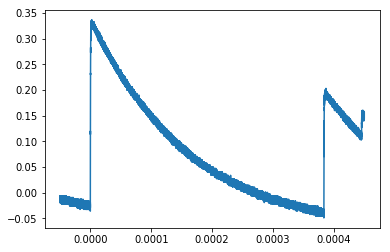

In [0]:
plt.plot(data1[:,0], data1[:, 1]*-1)

In [0]:
def moving_avg(a, x, prev):
  return (x+a*prev)/(1+a)
data1[:, 1] = data1[:, 1]*-1
h=[];
diff = []
a = 0.9
prev_y = data[0][1]
for i in data[1:, 1]:
  diff.append(abs(i-prev_y))
  if (abs(i-prev_y)>0.025):
    h.append(abs(i-prev_y))
  prev_y = i


In [0]:
def getdiff(file):
  data = np.genfromtxt(file, delimiter=',')
  data[:, 1] = data[:, 1]*-1
  t = abs(data[1:, 1]-data[:-1, 1])
  return np.array(t)
  

In [0]:
x = getdiff('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt')
for i in range(307, 401):
  t = getdiff('/content/drive/My Drive/DPP/outtest2/C1--Trace--00{}.trc.txt'.format(i))
  x = np.concatenate((x, t), axis=0)

In [0]:
data = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt', delimiter=',')
data[:, 1] = data[:, 1]*-1
prev = data[0, 1]
a = 0.5; a1=0.99
l = [data[0, 1]]
for i in range(len(data[1:, 1])):
  x = data[i, 1]
  l.append((prev+a*x)/(1+a))
  prev = prev*a1+(1-a1)*x

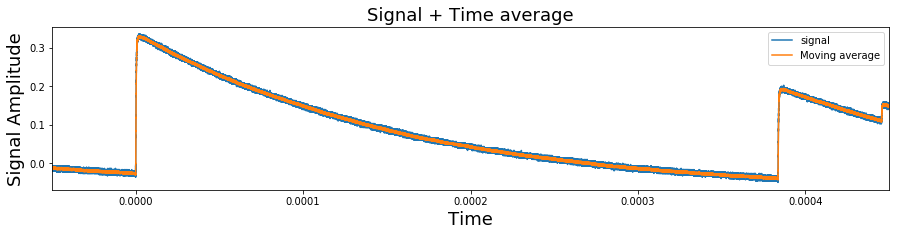

In [0]:
#plt.plot(data[:, 0], l)
#plt.plot(data[:, 0], data[:, 1])
#plt.show()
fig, ax= plt.subplots(figsize=(15, 3))
#time_ave, signal_ave = get_ave_values(time, signal, average_over)
ax.plot(data[:, 0], data[:, 1], label='signal')
ax.plot(data[:, 0], l, label='Moving average')
ax.set_xlim(data[0, 0], data[-1, 0])
ax.set_ylabel('Signal Amplitude', fontsize=18)
ax.set_title('Signal + Time average', fontsize=18)
ax.set_xlabel('Time', fontsize=18)
ax.legend()
plt.show()

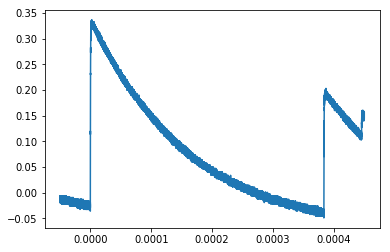

In [0]:
#x = np.concatenate((t1, t2), axis=0)
plt.plot(data[:, 0], data[:, 1])

In [0]:
#np.median(t)
t3 = t1
t3 = np.delete(t3, np.where(t3<0.014))
t3 = np.delete(t3, np.where(t3>0.019))

In [0]:
max(data[:, 1]), data[0, 1]

(0.382293, -0.0162189)

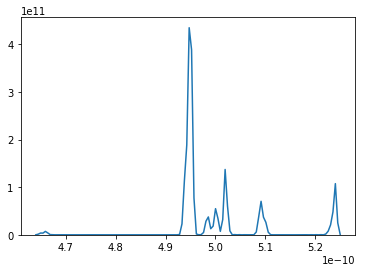

In [0]:
sns.distplot(t, hist=False)

In [0]:
## getting familiar with wavelet transform using El-nino dataset
import os
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns
import h5py

In [0]:
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


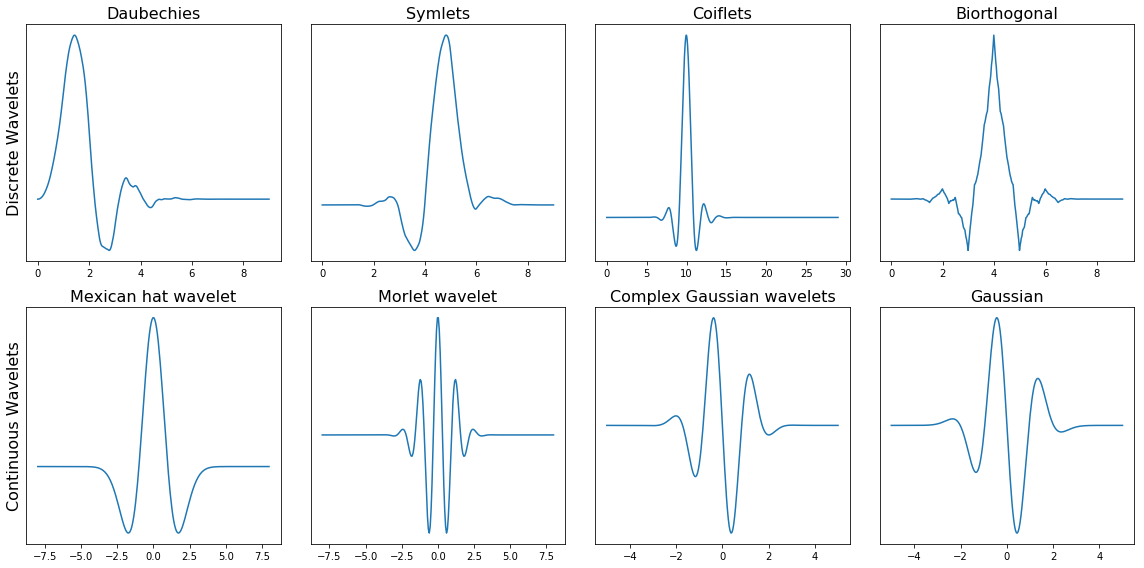

In [0]:
## Visualizing different wavelets
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(nrows = 2, ncols = 4, figsize = (16, 8))
for ii, list_wavelets in enumerate(list_list_wavelets):
  funcs = list_funcs[ii]
  row_no = ii
  for col_no, wavelet_name in enumerate(list_wavelets):
    wavelet = funcs(wavelet_name)
    family_name = wavelet.family_name
    biorthogonal = wavelet.biorthogonal
    orthogonal = wavelet.orthogonal
    symmetry = wavelet.symmetry
    if ii==0:
      _ = wavelet.wavefun()
      wavelet_function = _[0]
      x_values = _[-1]
    else :
      wavelet_function, x_values = wavelet.wavefun()
    if col_no==0 and ii==0:
      axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
    if col_no==0 and ii==1:
      axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
    axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
    axarr[row_no, col_no].plot(x_values, wavelet_function)
    axarr[row_no, col_no].set_yticks([])
    axarr[row_no, col_no].set_yticklabels([])
    
plt.tight_layout()
plt.show()

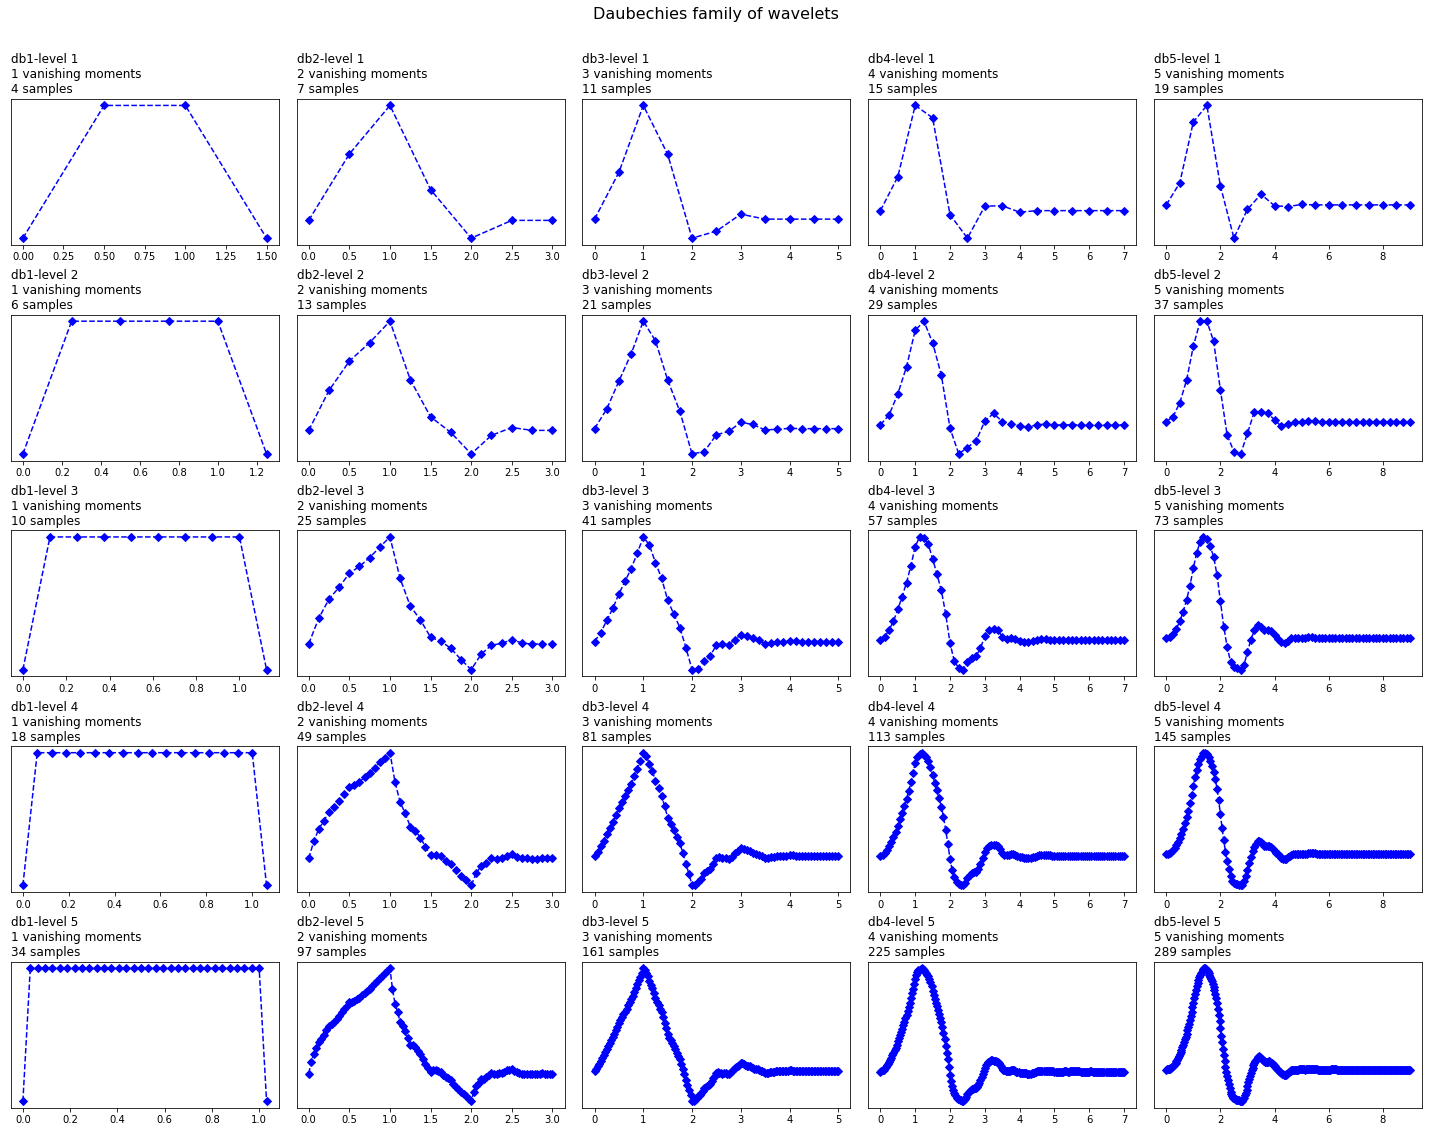

In [0]:
db_wavelets = pywt.wavelist('db')[:5]

fig, axarr = plt.subplots(nrows=5, ncols =5, figsize=(20, 16))
fig.suptitle('Daubechies family of wavelets', fontsize=16)
for col_no, wavelet_name in enumerate(db_wavelets):
  wavelet = pywt.Wavelet(wavelet_name)
  no_moments = wavelet.vanishing_moments_psi
  family_name = wavelet.family_name
  for row_no, level in enumerate(range(1,6)):
    wavelet_function, scaling_function, x_values = wavelet.wavefun(level=level)
    axarr[row_no, col_no].set_title("{}-level {}\n{} vanishing moments\n{} samples".format(wavelet_name, level, no_moments, len(x_values)), loc='left')
    axarr[row_no, col_no].plot(x_values, wavelet_function, 'bD--')
    axarr[row_no, col_no].set_yticks([])
    axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

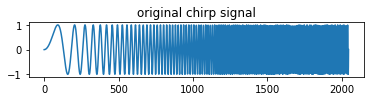

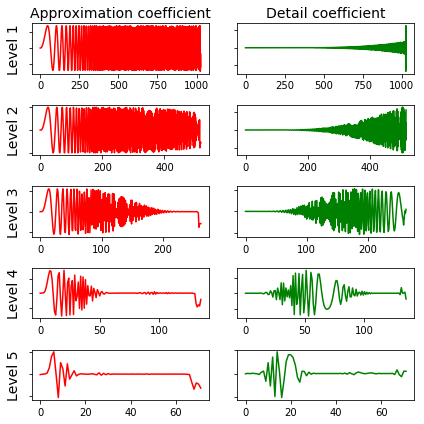

In [0]:
## expermenting with a chirp signal
x = np.linspace(0, 1, num =2048)
chirp_signal = np.sin(250*np.pi*x**2)

fig, ax  = plt.subplots(figsize=(6,1))
ax.set_title("original chirp signal")
ax.plot(chirp_signal)
plt.show()

data = chirp_signal
waveletname = 'sym5'

fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6, 6))
for ii in range(5):
  (data, coeff_d) = pywt.dwt(data, waveletname)
  axarr[ii, 0].plot(data, 'r')
  axarr[ii, 1].plot(coeff_d, 'g')
  axarr[ii, 0].set_ylabel("Level {}".format(ii+1), fontsize=14, rotation=90)
  axarr[ii, 0].set_yticklabels([])
  if ii==0:
    axarr[ii, 0].set_title("Approximation coefficient", fontsize=14)
    axarr[ii, 1].set_title("Detail coefficient", fontsize=14)
  axarr[ii, 1].set_yticklabels([])
  
plt.tight_layout()
plt.show()

In [0]:
elnino = np.genfromtxt('/content/drive/My Drive/elnino.csv', delimiter=',')

In [0]:
# load the el-nino dataset
dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_csv(dataset, sep='\t')
N = df_nino.shape[0]
t0 = 1871
dt = 0.25
time = np.arange(0, N)*dt + t0
signal = df_nino.values.squeeze()

In [0]:
data = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00306.trc.txt', delimiter=',')
signal = data[:, 1]*-1
time = data[:, 0]

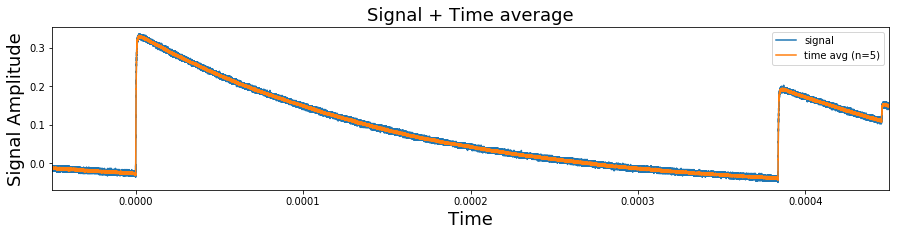

In [0]:
# plotting data along with average

def get_ave_values(x_values, y_values, n=5):
  signal_len = len(x_values)
  if signal_len%n==0:
    padding_len = 0
  else :
    padding_len = n-signal//n%n
  xarr = np.array(x_values)
  yarr = np.array(y_values)
  xarr.resize(signal_len//n, n)
  yarr.resize(signal_len//n, n)
  xarr_reshaped = xarr.reshape((-1, n))
  yarr_reshaped = yarr.reshape((-1, n))
  x_ave = xarr_reshaped[:, 0]
  y_ave = np.nanmean(yarr_reshaped, axis=1)
  return x_ave, y_ave

def plot_signal_plus_average(time, signal, average_over=5):
  fig, ax= plt.subplots(figsize=(15, 3))
  time_ave, signal_ave = get_ave_values(time, signal, average_over)
  ax.plot(time, signal, label='signal')
  ax.plot(time_ave, signal_ave, label='time avg (n={})'.format(average_over))
  ax.set_xlim(time[0], time[-1])
  ax.set_ylabel('Signal Amplitude', fontsize=18)
  ax.set_title('Signal + Time average', fontsize=18)
  ax.set_xlabel('Time', fontsize=18)
  ax.legend()
  plt.show()
  
plot_signal_plus_average(time, signal)

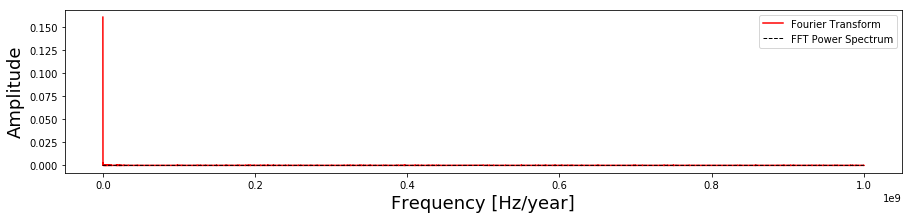

In [0]:
# plotting fourier transform of the data
def get_fft_values(y_values, T, N, f_s):
  f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
  fft_values_ = fft(y_values)
  fft_values = 2.0/N*np.abs(fft_values_[0:N//2])
  return f_values, fft_values

def plot_fft_plus_power(time, signal):
  dt = time[1]-time[0]
  N=len(signal)
  fs = 1/dt
  
  fig, ax= plt.subplots(figsize=(15, 3))
  variance = np.std(signal)**2
  f_values, fft_values = get_fft_values(signal, dt, N, fs)
  fft_power = variance*abs(fft_values)**2
  ax.plot(f_values, fft_values, 'r-', label = 'Fourier Transform')
  ax.plot(f_values, fft_power, 'k--', linewidth=1, label = 'FFT Power Spectrum')
  ax.set_xlabel('Frequency [Hz/year]', fontsize=18)
  ax.set_ylabel('Amplitude', fontsize=18)
  ax.legend()
  plt.show()

plot_fft_plus_power(time, signal)

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:74: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':


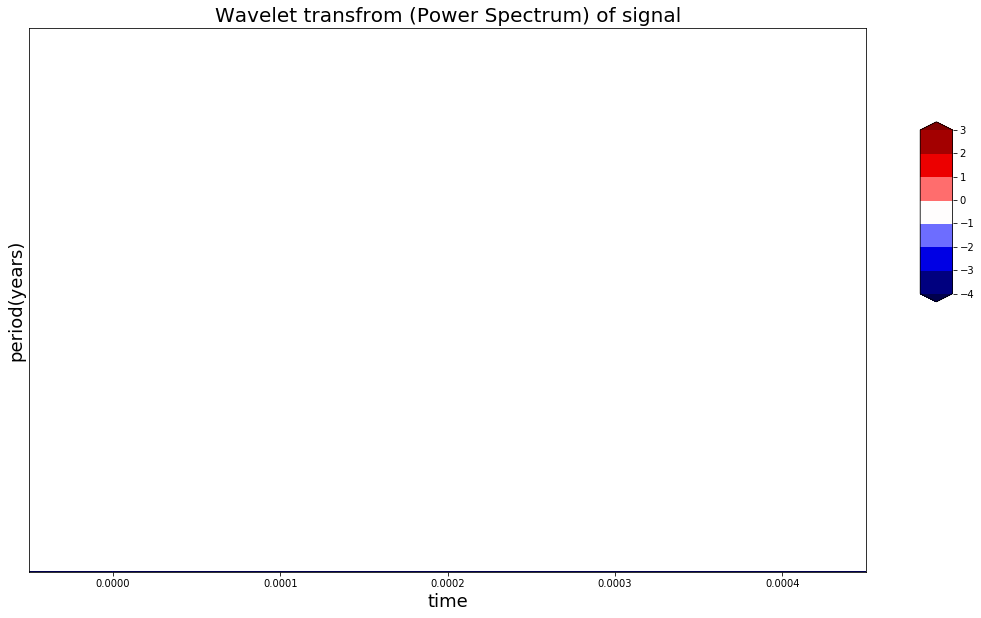

In [0]:
# plot scaleogram using Continuous wavelet Transform
def plot_wavelet(time, signal, scales, waveletname='cmor',
                 cmap=plt.cm.seismic, title='Wavelet transfrom (Power Spectrum) of signal',
                 ylabel = 'period(years)', xlabel='time'):
  dt = time[1]-time[0]
  [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
  power = (abs(coefficients))**2
  period = 1./frequencies
  levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
  contourlevels = np.log2(levels)
  
  fig, ax = plt.subplots(figsize=(15, 10))
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)
  
  ax.set_title(title, fontsize=20)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.set_xlabel(xlabel, fontsize=18)
  
  yticks = 2**(np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max()))))
  ax.set_yticks(np.log2(yticks))
  ax.set_yticklabels(yticks)
  ax.invert_yaxis()
  ylim = ax.get_ylim()
  ax.set_ylim(ylim[0], -1)
               
  cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
  fig.colorbar(im, cax = cbar_ax, orientation='vertical')
  plt.show()


scales = np.arange(1, 128)
plot_wavelet(time, signal, scales)

In [0]:
import scipy.io as sio
from IPython.display import display
import scipy.stats
import datetime as dt
from collections import defaultdict

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [0]:
dict_classifier = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Ada Boost": AdaBoostClassifier,
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "K-Nearest": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB(),
    "Gaussian Process": GaussianProcessClassifier(),
}

def batch_classify(X_train, Y_train, X_test, Y_test, no_classifier=5, verbose=True):
  dict_models={}
  for classifier_name, classifier in list(dict_classifier.items())[:no_classifier]:
    t_start = time.clock()
    classifier.fit(X_train, Y_train)
    t_end = time.clock()
    
    t_diff = t_end-t_start
    train_score = classifier.score(X_train, Y_train)
    test_score = classifier.score(X_test, Y_test)
    
    dict_model[classifier_name] = {'model':classifier,
                                   'train_score': train_score, 
                                   'test_score': test_score,
                                   'train time': t_diff}
    if verbose:
      print('Trained {c} in {f:.2f} s'.format(c=classifier_name, f=t_diff))
  return dict_model
  
def get_train_test(df, y_cols, x_cols, ratio):
  mask = np.random.rand(len(df))<ratio
  df_train = df[mask]
  df_test = df[~mask]
  
  Y_train = df_train[y_cols].values
  X_train = df_train[x_cols].values
  Y_test = df_test[y_cols].values
  X_test = df_test[x_cols].values
  
  return df_train, df_test, Y_train, X_train, Y_test, X_test

def display_dict_models(dict_model, sort_by='test_score'):
  clf = [key for key in dict_model.keys()]
  test_s = [dict_model[key]['test_score'] for key in clf]
  train_s = [dict_model[key]['train_score'] for key in clf]
  train_t = [dict_model[key]['train time'] for key in clf]
  
  df_ = pd.DataFrame(np.zeros(shape=(len(clf), 4)), columns=['classifier', 'test_score', 'train_score', 'train_time'])
  for ii in range(0, len(cls)):
    df_[ii, 'classifier'] = cls[ii]
    df_[ii, 'test_score'] = test_s[ii]
    df_[ii, 'train_score'] = train_s[ii]
    df_[ii, 'train_time'] = train_t[ii]
    
  display(df_.sort_values(by=sort_by, ascending=False))
  
def get_entropy(list_values):
  counter_values = Counter(list_values).most_common()
  prob = [elem[1]/len(list_values) for elem in counter_values]
  entropy = scipy.stats.entropy(prob)
  return entropy

def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  median = np.nanpercentile(list_values, 50)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, median, mean , std, var, rms]

def calculate_crossings(list_values):
  zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)>0))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.nonzero(np.diff(bp.array(list_values)>np.nanmean(list_values)))[0]
  no_mean_crossings = len(mena_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
  entropy = get_entropy(list_values)
  no_crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy]+no_crossings+statistics

def get_uci_har_features(dataset, labels, waveletname):
  uci_har_features = []
  for signal_no in range(0, len(dataset)):
    features = []
    for signal_comp in range(0, dataset.shape[2]):
      signal = dataset[signal_no, :, signal_comp]
      list_coeff = pywt.wavedec(signal, waveletname)
      for coeff in list_coeff:
        features+=get_features(coeff)
    uci_har_features.append(features)
  X = np.array(uci_har_features)
  Y = np.array(labels)
  return X, Y

In [0]:
# loading the UCI_HAR Dataset
activities_description = {
    1:'walking',
    2:'walking upstairs',
    3:'walking downstairs',
    4:'sitting',
    5:'standing',
    6:'lying'
}
def read_signal(filename):
  with open(filename, 'r') as f:
    data = f.read().splitlines()
    data = map(lambda x: x.rstrip().lstrip().split(), data)
    data = [list(map(float, line)) for line in data]
  return data

def read_labels(filename):
  with open(filename, 'r') as f:
    activities = f.read().splitlines()
    activities = list(map(int, activities))
  return activities

def randomize(dataset, labels):
  perm = np.random.permutations(labels.shape[0])
  shuffled_dataset = dataset[perm, :, :]
  shuffled_labels = labels[perm]
  return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = './data/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = './data/UCI_HAR/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = './data/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = './data/UCI_HAR/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
  signal = read_signal(INPUT_FOLDER_TRAIN+input_file)
  train_signals.append(signal)
tarin_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
  signal = read_signal(INPUT_FOLDER_TEST+input_file)
  test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = train_signals.shape
[no_signals_test, no_steps_test, no_components_test] = test_signals.shape
no_labels = len(np.unique(train_labels[:]))

print('The train dataset contains {} signals, each one of length {} and {} components'.format(no_signals_train, no_steps_train, no_components_train))
print('The test dataset contains {} signals, each of length {} and {} components'.format(no_signals_test, no_steps_test, no_components_test))
print('The train dataset contains {} labels with the following distribution \n{}'.format(np.shape(train_labels)[0], Counter(train_labels[:])))
print('The test dataset contains {} labels with the following distribution \n{}'.format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_train_signals, uci_har_train_labels = randomize(train_signals, np.array(train_labels))
uci_har_test_signals, uci_har_test_labels = randomize(test_signals, np.array(test_labels))

FileNotFoundError: ignored

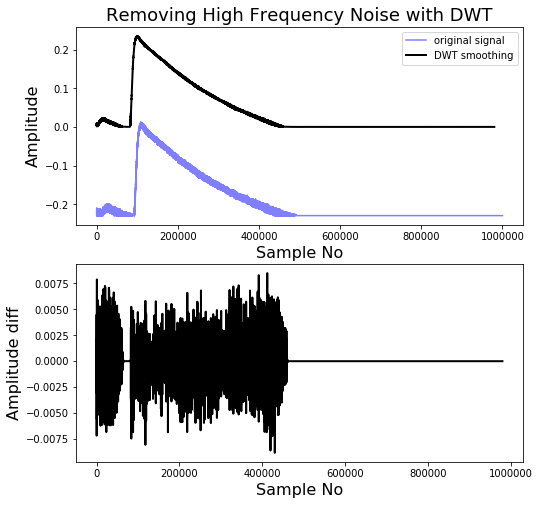

In [0]:
# removing high frequency noise
signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00464.trc.txt', delimiter=',')
signal = signal[:, 1]*-1

def lowpassfilter(signal, thres = 0.64, wavelet='db4'):
  thres = thres*np.nanmax(signal)
  coeff = pywt.wavedec(signal, wavelet, mode='per')
  coeff[1:] = (pywt.threshold(i, value=thres, mode='soft') for i in coeff[1:])
  reconstructed_signal = pywt.waverec(coeff, wavelet, mode='per')
  return reconstructed_signal

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8, 8))
ax[0].plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4, 'db4')[10000:-10000]
rec_mod = rec-min(rec)
diff = rec_mod[1:]-rec_mod[:-1]
ax[0].plot(rec_mod, 'k', label='DWT smoothing', linewidth=2)
ax[0].legend()
ax[1].plot(diff, 'k', label='Height difference', linewidth=2)
ax[0].set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[1].set_ylabel('Amplitude diff', fontsize=16)
ax[0].set_xlabel('Sample No', fontsize=16)
ax[1].set_xlabel('Sample No', fontsize=16)
plt.show()

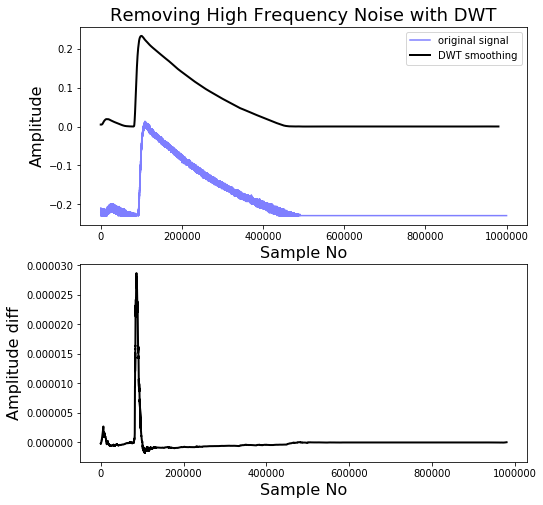

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8, 8))
ax[0].plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.8)
rec_2  = lowpassfilter(rec, 0.8)
#rec_3 = lowpassfilter(rec_2, 0.4)
#rec_4 = lowpassfilter(rec_3, 0.4)
rec_crop = rec_2[10000:-10000]
rec_mod = rec_crop-min(rec_crop)
diff = rec_mod[1:]-rec_mod[:-1]
ax[0].plot(rec_mod, 'k', label='DWT smoothing', linewidth=2)
ax[0].legend()
ax[1].plot(diff, 'k', label='Height difference', linewidth=2)
ax[0].set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[1].set_ylabel('Amplitude diff', fontsize=16)
ax[0].set_xlabel('Sample No', fontsize=16)
ax[1].set_xlabel('Sample No', fontsize=16)
plt.show()

In [0]:
a = (np.max(diff)+abs(np.min(diff)))*0.5
peaks = np.where(diff>a)[0]
len(peaks)
prev = peaks[0]
peaks_mod = [peaks[0]]
for i in range(1, len(peaks)):
  if (peaks[i]-peaks[i-1]>200000):
    peaks_mod.append(peaks[i])
len(peaks_mod)

2

In [0]:
def find_peaks(diff):
  #thre = (np.max(diff)+np.abs(np.min(diff)))*0.5
  thre = np.max(diff)*0.5  
  peaks = np.where(diff>thre)[0]
  peaks_mod = [peaks[0]]  # cluster the time values to get distinct peaks
  for i in range(1, len(peaks)):
    if (peaks[i]-peaks[i-1]>200000):
      peaks_mod.append(peaks[i])
  return peaks_mod

def get_window(signal, peaks, window_sz=200000):
  cropped_signals=[]
  n = len(signal)
  for i in peaks:
      sig = signal[max(0, i-window_sz):min(n, i+window_sz)]
      cropped_signals.append(sig)
  return cropped_signals

In [0]:
def maxSubArraySum(a,size): 
    maxint = 10.0   
    max_so_far = -maxint - 1
    max_ending_here = 0
       
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if (max_so_far < max_ending_here): 
            max_so_far = max_ending_here
  
        if max_ending_here < 0: 
            max_ending_here = 0   
    return max_so_far 

In [0]:
# Analysing time complexity of different functions
t = time.time()
i = 464
signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00{}.trc.txt'.format(i), delimiter=',')
signal = signal[:, 1]*-1
t_load = time.time()-t
t = time.time()
rec = lowpassfilter(signal, 0.4)[10000:-10000]
rec_mod = rec-min(rec)
diff = rec_mod[1:]-rec_mod[:-1]
t_diff = time.time()-t
t = time.time()
peaks = find_peaks(diff)
print(len(peaks))
t_peak = time.time()-t
t = time.time()
cropped_signals = get_window(diff, peaks)
t_window = time.time()-t
t = time.time()
for sig in cropped_signals:
  th = maxSubArraySum(sig, sig.shape[0])
t_height = time.time()-t
print("Time required for: \n 1.Loading data = ", t_load,
      "\n 2.Denoising data = ", t_diff,
      "\n 3.Finding peaks = ", t_peak,
      "\n 4.Cropping signals around peaks = ", t_window, 
      "\n 5.Getting heights = ", t_height)

"""
To decrease data loading time: Load once and save it for further processing.
      Need to experiment with denoising hence, can't save denoised data.
      
To decrease the time for finding height: tighten the bound around peaks to
      decrease window size as the time complexity of the the algorithm is O(n).
      
Also try decreasing the sampling rate, analyse performance-sampling rate
trade-off.
"""

1
Time required for: 
 1.Loading data =  3.334554433822632 
 2.Denoising data =  0.15912771224975586 
 3.Finding peaks =  0.0063860416412353516 
 4.Cropping signals around peaks =  0.00010514259338378906 
 5.Getting heights =  0.10799884796142578


In [0]:
# Saving data in h5py format
h5_data = []
t = time.time()
"""
for i in range(306, 1000):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--00{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  h5_data.append(signal)
  t2 = time.time()
  print("Signal ", i, " loaded in time ", t2-t, "s")
  t = t2

for i in range(1000, 2001):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--0{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  h5_data.append(signal)
  t2 = time.time()
  print("Signal ", i, " loaded in time ", t2-t, "s")
  t = t2
"""
for i in range(3526, 3994):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--0{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  h5_data.append(signal)
  t2 = time.time()
  print("Signal ", i, " loaded in time ", t2-t, "s")
  t = t2
h5 = h5py.File("/content/drive/My Drive/Dpp_data_3.5k_4k.h5py", "w")
h5.create_dataset("main", data=h5_data)
h5.close()

Signal  3526  loaded in time  3.4688775539398193 s


In [0]:
t = time.time()
dpp_data = h5py.File("/content/drive/My Drive/Dpp_data.h5py", "r")["main"]
t_h5 = time.time()-t
t = time.time()
dpp_sig = dpp_data[0]
t_1 = time.time()-t
print("Time to load the h5py file: ", t_h5,
      "\n Avg time per signal: ", t_h5*0.1,
      "\n Time to access a signal: ", t_1,)

Time to load the h5py file:  0.0020875930786132812 
 Avg time per signal:  0.00020875930786132813 
 Time to access a signal:  0.02496051788330078


In [0]:
# loading data to debug unusual spectrum shape(no compton scattering after the peak)
dpp_data = h5py.File("/content/drive/My Drive/Dpp_data.h5py", "r")["main"]

In [0]:
t = maxSubArraySum(diff, diff.shape[0])

In [0]:
len(h5_data)

NameError: ignored

In [0]:
#import time
#heights = []
errorneous_samples = []  # collecting samples to analyse for insufficient noise reduction
t1 = time.time()
for i in range(1000, 2001):
  signal = np.genfromtxt('/content/drive/My Drive/DPP/outtest2/C1--Trace--0{}.trc.txt'.format(i), delimiter=',')
  signal = signal[:, 1]*-1
  rec = lowpassfilter(signal, 0.4)[10000:-10000]  ## cropping signal to remove edge effect
  rec_mod = rec-min(rec)
  diff = rec_mod[1:]-rec_mod[:-1]
  peaks = find_peaks(diff)
  if (len(peaks)>3):
    errorneous_samples.append(i)
  '''
  cropped_signals = get_window(diff, peaks)
  for sig in cropped_signals:
    t = maxSubArraySum(sig, sig.shape[0])
    heights.append(t)
  '''
  if (i%10==0):
    print("Batch done, time taken: ", time.time()-t1)
    t1 = time.time()

Batch done, time taken:  4.017955541610718


/usr/local/lib/python3.6/dist-packages/pywt/_thresholding.py:25: RuntimeWarning: invalid value encountered in multiply
  thresholded = data * thresholded
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Batch done, time taken:  39.736987352371216
Batch done, time taken:  39.99190640449524
Batch done, time taken:  39.678593158721924


KeyboardInterrupt: ignored

In [0]:
thre = (np.max(diff)+np.abs(np.min(diff)))*0.5
peaks = np.where(diff>thre)[0]
np.max(diff)

0.007444244097171093

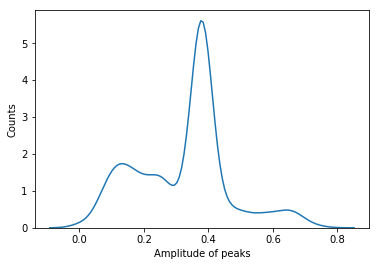

In [0]:
#import seaborn as sns
ax = sns.distplot(heights, hist=False)
ax.set_ylabel('Counts')
ax.set_xlabel('Amplitude of peaks')
plt.show()

In [0]:
t

0.3589674964623943

In [0]:
### Trying VAE on the dataset
#--- imports ---
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
import os

In [0]:
num_epoches = 100
batch_size = 10
learning rate = 1e-3

class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.fc1 = nn.Linear(784, 400);
    self.fc21 = nn.Linear(400, 20);
    self.fc22 = nn.LInear(400, 20);
    self.fc3 = nn.Linear(20, 400);
    self.fc4 = nn.Linear(400, 784);

In [0]:
## Random stuff
# map 2-d grid on a sphere
"""
def mapping(x, y, r):
  longitude = x/r;
  latitude = 2*np.arctan(np.exp(y/r)) - np.pi/2;
  new_pts = np.zeros([x.shape, 3])
  new_pts[0] = r * np.cos(latitude) * np.cos(latitude) # x
  new_pts[1] = r * np.cos(latitude) * np.sin(latitude) # y
  new_pts[2] = r * np.sin(latitude) # z
  return new_pts
# function to convert cartisian coordinates to spherical (not useful)

def Spherical_np(xyz):
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

def mapping(x, y, r):
  longitude = x/r
  latitude = 2*np.arctan(np.exp(y/r)) - np.pi/2
  new_pts = np.zeros([x.shape[0], 3])
  new_pts[:, 0] = r * np.cos(latitude) * np.cos(latitude) # x
  new_pts[:, 1] = r * np.cos(latitude) * np.sin(latitude) # y
  new_pts[:, 2] = r * np.sin(latitude) # z
  return new_pts
"""

'\ndef Spherical_np(xyz):\n    ptsnew = np.zeros(xyz.shape)\n    xy = xyz[:,0]**2 + xyz[:,1]**2\n    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)\n    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down\n    #ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up\n    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])\n    return ptsnew\n'